# Imports

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import math
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
import re
import string
import spacy
import contractions

import shap

# Vectorización TF-IDF + Redes Neuronales MLPs

Aunque el Random Forest ha logrado una precisión del 98.4% en la detección de noticias falsas, es valioso explorar el desempeño de **redes neuronales**, ya que pueden capturar patrones complejos en los datos. 

En primer lugar, utilizaremos la misma vectorización TF-IDF, evaluaremos si modelos neuronales ofrecen ventajas adicionales en términos de generalización y robustez. 

Más tarde, probaremos con otras **formas de vectorización**. 

Para terminar, exploraremos si **redes neuronales recurrentes** (RNNs) ofrecen un rendimiento superior al capturar dependencias secuenciales y contextuales en los textos.

## División en Train, Validation & Test para Redes Neuronales

In [ ]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28283,)
Shape of X_valid: (7071,)
Shape of X_test: (8839,)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


##  Vectorización mediante TF-IDF + Red Neuronal MLP

#### Tokenización y Tensorización

In [ ]:
# Definir y ajustar el vectorizador TF-IDF en el conjunto de entrenamiento
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)

# Transformar los conjuntos de validación y prueba utilizando el vectorizador ajustado
X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)

# Verificar las dimensiones de los conjuntos transformados
print("Shape of X_train_tfidf:", X_train.shape)
print("Shape of X_valid_tfidf:", X_valid.shape)
print("Shape of X_test_tfidf:", X_test.shape)

Shape of X_train_tfidf: (28283, 5000)
Shape of X_valid_tfidf: (7071, 5000)
Shape of X_test_tfidf: (8839, 5000)


Los **tensores** son estructuras de datos multidimensionales similares a matrices que pueden representar datos en múltiples dimensiones. 

En **PyTorch**, los tensores son el núcleo de su funcionalidad, ya que permiten realizar operaciones matemáticas eficientes y aprovechar la aceleración por hardware, como GPUs.

Es necesario **convertir los datos a tensores** en PyTorch porque este formato es compatible con las operaciones optimizadas de la biblioteca, como el cálculo de gradientes automáticos y el entrenamiento de modelos.

In [ ]:
# Convertir datos a tensores de PyTorch
def tensorize(data, labels, device):
    data_tensor = torch.tensor(data.toarray(), dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    return data_tensor, labels_tensor

In [ ]:
# Verificar si la GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Tensorizar los conjuntos de datos
X_train_tensor, y_train_tensor = tensorize(X_train, y_train, device)
X_valid_tensor, y_valid_tensor = tensorize(X_valid, y_valid, device)
X_test_tensor, y_test_tensor = tensorize(X_test, y_test, device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)

Using device: cuda
Shape of X_train_tensor: torch.Size([28283, 5000])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 5000])
Shape of y_valid_tensor: torch.Size([7071, 1])


In [ ]:
# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Variables de configuración
batch_size = 128

# Crear DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Definición del modelo

In [ ]:
# Definimos modelo MLP
mlp_model = nn.Sequential(
    nn.Linear(5000, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

#### Funciones para entrenamiento y validación

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path):
    """
    Entrena el modelo MLP y guarda el mejor modelo basado en la pérdida de validación.
    
    Args:
        model: El modelo MLP a entrenar.
        train_loader: DataLoader para el conjunto de entrenamiento.
        valid_loader: DataLoader para el conjunto de validación.
        criterion: Función de pérdida.
        optimizer: Optimizador.
        num_epochs: Número de épocas para entrenar.
        device: Dispositivo (CPU o GPU).
        best_model_path: Ruta para guardar el mejor modelo.
    """
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_loss = float("inf")

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        valid_loss, correct_valid, total_valid = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct_valid += (predicted == y_batch).sum().item()
                total_valid += y_batch.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_valid / total_valid)

        # Guardar el mejor modelo
        if valid_losses[-1] < best_val_loss:
            best_val_loss = valid_losses[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"🔹 Saved best model at {best_model_path} (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f} - Val Loss: {valid_losses[-1]:.4f} - Val Acc: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
def plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies):
    """
    Función para graficar la pérdida y precisión de entrenamiento y validación a lo largo de las épocas.

    Args:
    - train_losses: Lista de pérdidas de entrenamiento para cada época.
    - valid_losses: Lista de pérdidas de validación para cada época.
    - train_accuracies: Lista de precisiones de entrenamiento para cada época.
    - valid_accuracies: Lista de precisiones de validación para cada época.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(valid_accuracies, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.show()

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evalúa el modelo en el conjunto de prueba utilizando un DataLoader para evitar problemas de memoria.

    Parámetros:
    - model: El modelo PyTorch entrenado.
    - test_loader: DataLoader para el conjunto de prueba.
    - device: El dispositivo (CPU/GPU) a usar para el cálculo.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
    auc_roc = roc_auc_score(all_labels, all_preds)
    print(f"AUC-ROC en el conjunto de prueba: {auc_roc:.4f}")

#### Entrenamiento y validación

🔹 Saved best model at models/best_mlp.pth (Val Loss: 0.0632)
Epoch [1/10] - Loss: 0.2038 - Acc: 0.9450 - Val Loss: 0.0632 - Val Acc: 0.9788
🔹 Saved best model at models/best_mlp.pth (Val Loss: 0.0550)
Epoch [2/10] - Loss: 0.0341 - Acc: 0.9900 - Val Loss: 0.0550 - Val Acc: 0.9818
Epoch [3/10] - Loss: 0.0147 - Acc: 0.9961 - Val Loss: 0.0564 - Val Acc: 0.9829
Epoch [4/10] - Loss: 0.0068 - Acc: 0.9987 - Val Loss: 0.0604 - Val Acc: 0.9827
Epoch [5/10] - Loss: 0.0028 - Acc: 0.9998 - Val Loss: 0.0663 - Val Acc: 0.9819
Epoch [6/10] - Loss: 0.0013 - Acc: 0.9999 - Val Loss: 0.0819 - Val Acc: 0.9826
Epoch [7/10] - Loss: 0.0006 - Acc: 1.0000 - Val Loss: 0.0856 - Val Acc: 0.9826
Epoch [8/10] - Loss: 0.0004 - Acc: 1.0000 - Val Loss: 0.0885 - Val Acc: 0.9827
Epoch [9/10] - Loss: 0.0002 - Acc: 1.0000 - Val Loss: 0.0918 - Val Acc: 0.9823
Epoch [10/10] - Loss: 0.0002 - Acc: 1.0000 - Val Loss: 0.0937 - Val Acc: 0.9830


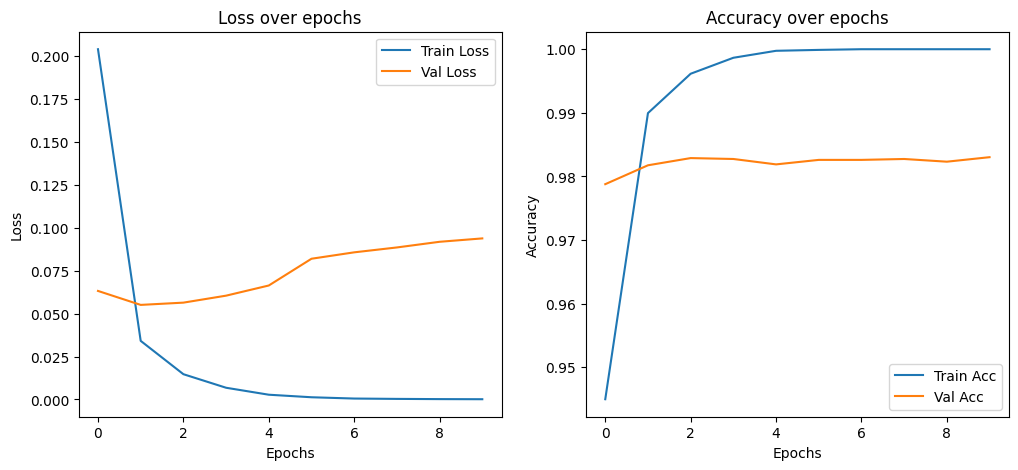

Precisión en el conjunto de prueba: 0.9848


In [ ]:
# Instanciar modelo y moverlo a GPU si está disponible
model = mlp_model.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 10
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_mlp.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Graficar pérdidas y precisiones
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

El modelo ha mostrado un rendimiento sobresaliente, alcanzando una precisión en validación cercana al 98.2% y una pérdida de 0.05 tras solo **tres épocas**. En el conjunto de prueba, se obtuvo el mejor desempeño con una precisión del **98.5%**.

## Vectorización mediante Embeddings (*BERT*) + Red Neuronal MLP

En lugar de utilizar **TF-IDF** como vectorización inicial, vamos a probar con embeddings como **BERT**, pues podría ser una excelente idea al capturar mejor el significado semántico del texto completo, a diferencia de TF-IDF, que se basa en la frecuencia de palabras y carece de contexto.
 
Además, BERT reduce significativamente la **dimensionalidad** (768 vs 5000), al mismo tiempo que captura relaciones más profundas en el texto, lo que puede optimizar la eficiencia computacional y reducir el riesgo de sobreajuste.

No obstante, hay que destacar que al usar **sentence-transformers** se obtiene una **única representación fija para cada noticia**, lo que sigue haciendo incompatible el uso de LSTMs, ya que no se trabaja con secuencias de vectores por palabra, sino con un solo embedding por entrada.

#### Vectorización mediante *Sentence-transformers*

El model de embeddings que se va a utilizar, **bert-base-nli-mean-tokens**, presenta las siguientes características:

- **`bert-base`** → Está basado en el modelo BERT con 12 capas, 768 dimensiones ocultas y 12 cabezas de atención.
- **`nli` (Inferencia de Lenguaje Natural)** → El modelo fue ajustado con datasets de NLI (SNLI + MNLI) para entender relaciones semánticas entre oraciones.
- **`mean-tokens`** → Utiliza un promedio de los embeddings de todos los tokens para crear embeddings de oraciones, en lugar de usar solo el token `[CLS]`.

In [ ]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = SentenceTransformer("bert-base-nli-mean-tokens") # Modelo rápido

# Convertir a embeddings
X_train_embedding = model.encode(X_train.tolist())
X_valid_embedding = model.encode(X_valid.tolist())
X_test_embedding = model.encode(X_test.tolist())

# Verificar las dimensiones de los conjuntos transformados
print("Shape of X_train_tfidf:", X_train.shape)
print("Shape of X_valid_tfidf:", X_valid.shape)
print("Shape of X_test_tfidf:", X_test.shape)

(28283, 768)

#### Entrenamiento y evaluación

🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.2037)
Epoch [1/20] - Loss: 0.2669 - Acc: 0.8901 - Val Loss: 0.2037 - Val Acc: 0.9192
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1752)
Epoch [2/20] - Loss: 0.1771 - Acc: 0.9323 - Val Loss: 0.1752 - Val Acc: 0.9320
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1622)
Epoch [3/20] - Loss: 0.1521 - Acc: 0.9427 - Val Loss: 0.1622 - Val Acc: 0.9349
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1435)
Epoch [4/20] - Loss: 0.1360 - Acc: 0.9474 - Val Loss: 0.1435 - Val Acc: 0.9441
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1340)
Epoch [5/20] - Loss: 0.1243 - Acc: 0.9528 - Val Loss: 0.1340 - Val Acc: 0.9485
Epoch [6/20] - Loss: 0.1198 - Acc: 0.9544 - Val Loss: 0.1576 - Val Acc: 0.9400
Epoch [7/20] - Loss: 0.1078 - Acc: 0.9587 - Val Loss: 0.1551 - Val Acc: 0.9419
🔹 Saved best model at models/best_mlp_embeddings.pth (Val Loss: 0.1215)
Epoch [8/20] - 

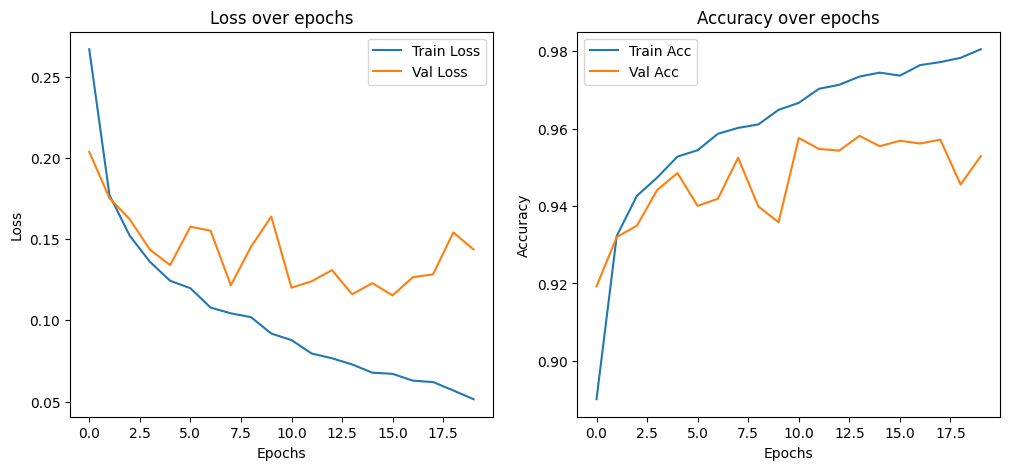

Precisión en el conjunto de prueba: 0.9628


In [ ]:
# GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir datos a tensores de PyTorch cuando ya son arrays
def tensorize_array(data, labels, device):
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    return data_tensor, labels_tensor

X_train_tensor, y_train_tensor = tensorize_array(X_train_embedding, y_train, device)
X_valid_tensor, y_valid_tensor = tensorize_array(X_valid_embedding, y_valid, device)
X_test_tensor, y_test_tensor = tensorize_array(X_test_embedding, y_test, device)

# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Variables de configuración
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definimos modelo MLP
mlp_model = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Instanciar modelo y moverlo a GPU si está disponible
model = mlp_model.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_mlp_embeddings.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Graficar pérdidas y precisiones
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

No se observa un rendimiento superior comparando con el modelo que utilizaba vectorización TF-IDF como entrada de la MLP, obteniendo un **96.3%** de precisión en el conjunto de prueba.

La **MLP** con **TF-IDF** podría funcionar mejor en la clasificación de noticias porque TF-IDF enfatiza **términos clave** específicos de cada noticia, lo que ayuda a **diferenciar mejor** las categorías. En cambio, **BERT**, al generar embeddings densos y compactos de 768 dimensiones, puede perder detalles relevantes al **comprimir la información** en un espacio más reducido.

# Vectorización mediante Embeddings + LSTM

La clasificación de fake news utilizando una **RNN (Recurrent Neural Network)** es una excelente idea debido a su capacidad para manejar **secuencias de texto** largas y complejas, lo cual es fundamental en el análisis de noticias. 

Las LSTM son especialmente efectivas para **capturar dependencias a largo plazo** en los datos, lo que permite identificar patrones y contextos importantes en las noticias, incluso cuando la información relevante está dispersa a lo largo del texto. 

Además, se escoge una red **LSTM (Long Short-Term Memory)** por su capacidad para mitigar el problema del desvanecimiento del gradiente, que afecta a otras redes neuronales recurrentes, lo que las hace muy adecuadas para procesar y clasificar textos de forma eficiente y precisa, mejorando la detección de desinformación en el proceso.

## División en Train, Validation & Test para Redes Neuronales

In [2]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [3]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28283,)
Shape of X_valid: (7071,)
Shape of X_test: (8839,)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


## Vectorización con Tokenizer + LSTM Básica

#### Tokenización y Tensorización

En cuanto a la vectorización de nuestras noticias, es importante destacar que **TF-IDF** se enfoca en ponderar la importancia de las palabras en los documentos, pero **no captura la secuencia temporal** ni el contexto de las palabras en el texto, lo que puede limitar el rendimiento en modelos que dependen de la información secuencial, como las LSTM.

Por esta razón, utilizaremos un tokenizador que **preserve el orden temporal**. En este caso, emplearemos el **Tokenizer** de *TensorFlow*, que convierte el texto en secuencias de índices enteros que representan palabras, manteniendo tanto el orden como la estructura temporal del texto.

El proceso que realiza **Tokenizer** es el siguiente:

- **Tokenización**: Primero, las noticias se dividen en palabras o subpalabras (*tokens*), y cada palabra se asigna a un número único (*índice*) dentro del vocabulario.

- **Vectorización**: El *Tokenizer* convierte cada noticia en una secuencia de índices que corresponden a las palabras en el vocabulario. Por ejemplo, como nuestro vocabulario tiene un tamaño de 5000 palabras, cada palabra en el texto se mapea a un número entre 0 y 4999.

Además, cada noticia, una vez convertida en una secuencia de índices, será transformada en una secuencia de exactamente **1256 elementos**. Esto se hace porque, de media, las noticias recogidas tenían una longitud media de 1656 palabras tras el preprocesado. Sin embargo, un número de elementos mayor podría empeorar el rendimiento del entrenamiento.

Todas las secuencias tendrán la misma longitud gracias a la función **pad_sequences** de *Tensorflow*, pues realiza dos acciones dependiendo de la longitud de la secuencia:
- Si la noticia tiene menos de 1256 palabras, se agrega padding (relleno) con ceros.
- Si la noticia tiene más de 1256 palabras, se trunca la secuenia para que tenga solo 1256 índices.

Por defecto, el padding y el truncado se realizan al inicio.



In [ ]:
# --------------------
# Tokenización y secuencias
# --------------------
# Disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Número máximo de palabras a considerar en el vocabulario
max_words = 5000
# Longitud máxima de las secuencias - La media de longitud de los textos es 1656 aproximadamente
max_len = 1256

# Inicializar el tokenizador de TensorFlow con un vocabulario limitado y un token para palabras 'Out-Of-Vocabulary'
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de índices y aplicar padding
X_train_embedding = tokenizer.texts_to_sequences(X_train)
X_train_embedding = pad_sequences(X_train_embedding, maxlen=max_len)
X_valid_embedding = tokenizer.texts_to_sequences(X_valid)
X_valid_embedding = pad_sequences(X_valid_embedding, maxlen=max_len)
X_test_embedding = tokenizer.texts_to_sequences(X_test)
X_test_embedding = pad_sequences(X_test_embedding, maxlen=max_len)

# Convertir a tensores de PyTorch --- Pasamos a device en el bucle de entrenamiento
X_train_tensor = torch.tensor(X_train_embedding, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_embedding, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_embedding, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Batch Size
batch_size = 128

# Crear Datasets & DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Usando device: cuda
Shape of X_train_tensor: torch.Size([28283, 1256])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1256])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1256])
Shape of y_test_tensor: torch.Size([8839, 1])


#### Definición del modelo

Para que el modelo **LSTM** funcione correctamente, es necesario que los datos de entrada tengan **tres dimensiones**. Actualmente, el tensor de entrenamiento tiene una forma de *torch.Size([28283, 1256])*, es decir, contiene secuencias de longitud 1256 para 28,283 muestras, pero aún le falta la dimensión correspondiente a la representación vectorial de cada palabra.

Esta tercera dimensión se añade mediante la capa de **Embedding**, la cual transforma cada índice entero (asociado a una palabra) en un **vector denso de características** continuas. Por ejemplo, si el índice 23 representa la palabra "economía", el Embedding devolverá un vector de dimensión 48 que captura sus propiedades semánticas. Así, el modelo puede aprender relaciones y patrones complejos entre palabras en función de su contexto, en lugar de tratarlas simplemente como identificadores numéricos.

Una vez procesadas las secuencias por la LSTM, se toma el **último estado oculto de la salida** (lstm_out[:, -1, :]), el cual resume la información contextual de toda la secuencia. Este vector condensado se pasa luego por una capa lineal para realizar la **clasificación binaria** entre noticias reales y falsas.

In [8]:
# --------------------
# Modelo LSTM
# --------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim=max_words, embedding_dim=48, hidden_dim=64):
        super(LSTMModel, self).__init__()
        # Capa de Embeddings
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Capa LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Dropout para regularización
        self.dropout = nn.Dropout(p=0.3)
        # Capa densa final con activación sigmoide
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)  # Embeddings -> (batch_size, max_len, embedding_dim) = (128, 1256, 48)
        lstm_out, _ = self.lstm(x)  # Pasamos por la LSTM
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Tomamos solo el último estado, capturando el contexto completo de la secuencia de entrada para hacer la clasificación
        out = self.fc(lstm_out)  # Pasamos por la capa densa (64 → 1)
        return self.sigmoid(out)  # Activación sigmoide

#### Funciones para entrenamiento y evaluación

In [4]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path):
    """
    Entrena el modelo LSTM y guarda el mejor modelo basado en la pérdida de validación.
        
    Args:
        model: El modelo MLP a entrenar.
        train_loader: DataLoader para el conjunto de entrenamiento.
        valid_loader: DataLoader para el conjunto de validación.
        criterion: Función de pérdida.
        optimizer: Optimizador.
        num_epochs: Número de épocas para entrenar.
        device: Dispositivo (CPU o GPU).
        best_model_path: Ruta para guardar el mejor modelo.
    """
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_loss = float("inf")

    # Entrenamiento
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        valid_loss, correct_valid, total_valid = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct_valid += (predicted == y_batch).sum().item()
                total_valid += y_batch.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct_valid / total_valid)

        # Guardar el mejor modelo
        if valid_losses[-1] < best_val_loss:
            best_val_loss = valid_losses[-1]
            torch.save(model.state_dict(), best_model_path)
            print(f"🔹 Saved best model at {best_model_path} (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f} - Val Loss: {valid_losses[-1]:.4f} - Val Acc: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [72]:
def plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies):
    """
    Función para graficar la pérdida y precisión de entrenamiento y validación a lo largo de las épocas.

    Args:
    - train_losses: Lista de pérdidas de entrenamiento para cada época.
    - valid_losses: Lista de pérdidas de validación para cada época.
    - train_accuracies: Lista de precisiones de entrenamiento para cada época.
    - valid_accuracies: Lista de precisiones de validación para cada época.
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(valid_accuracies, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()

    plt.show()

In [73]:
def evaluate_model(model, test_loader, device, best_model_path):
    """
    Carga un modelo y lo evalúa en el conjunto de prueba utilizando un DataLoader para evitar problemas de memoria.

    Parámetros:
    - model: El modelo PyTorch entrenado.
    - test_loader: DataLoader para el conjunto de prueba.
    - device: El dispositivo (CPU/GPU) a usar para el cálculo.
    - best_model_path: Ruta para guardar el mejor modelo.
    """

    # Cargar el mejor modelo
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
    auc_roc = roc_auc_score(all_labels, all_preds)
    print(f"AUC-ROC en el conjunto de prueba: {auc_roc:.4f}")

#### Entrenamiento y evaluación

🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1961)
Epoch [1/20] - Loss: 0.3592 - Acc: 0.8348 - Val Loss: 0.1961 - Val Acc: 0.9242
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1726)
Epoch [2/20] - Loss: 0.2381 - Acc: 0.9079 - Val Loss: 0.1726 - Val Acc: 0.9381
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1278)
Epoch [3/20] - Loss: 0.1513 - Acc: 0.9466 - Val Loss: 0.1278 - Val Acc: 0.9559
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.1208)
Epoch [4/20] - Loss: 0.1164 - Acc: 0.9600 - Val Loss: 0.1208 - Val Acc: 0.9604
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.0967)
Epoch [5/20] - Loss: 0.1006 - Acc: 0.9673 - Val Loss: 0.0967 - Val Acc: 0.9686
Epoch [6/20] - Loss: 0.1054 - Acc: 0.9657 - Val Loss: 0.1156 - Val Acc: 0.9574
🔹 Saved best model at models/best_lstm_embeddings.pth (Val Loss: 0.0886)
Epoch [7/20] - Loss: 0.0764 - Acc: 0.9752 - Val Loss: 0.0886 - Val Acc: 0.9679
Epoch [8/

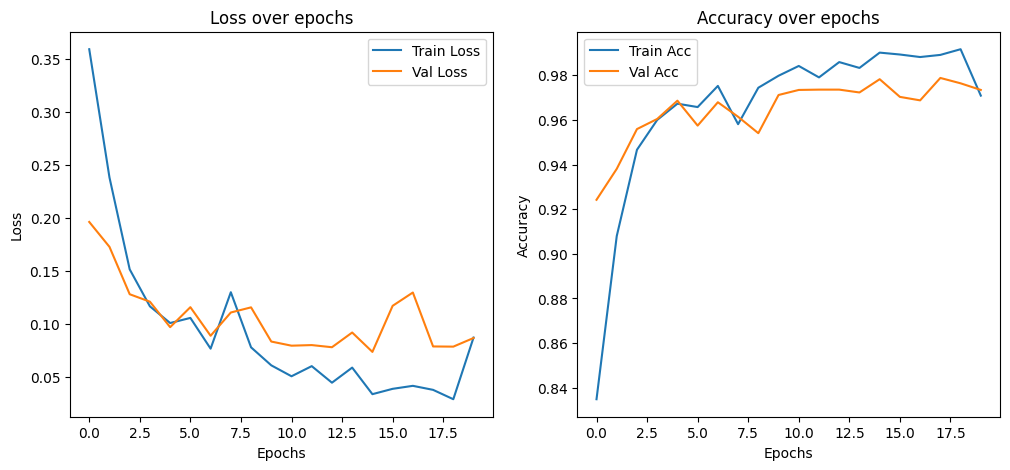

Precisión en el conjunto de prueba: 0.9792


In [ ]:
# --------------------
# Entrenamiento y evaluación
# --------------------

# Instanciar modelo, pérdida y optimizador
model = LSTMModel().to(device)
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de ntrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
best_model_path = "models/best_lstm.pth"  # Ruta donde se guardará el mejor modelo

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device)

Aunque el modelo alcanza un **98%** de precisión en el conjunto de prueba, se concluye que no supera el rendimiento de modelos anteriores, a pesar de ser **notablemente más complejo** desde el punto de vista computacional. Sin embargo, aún quedan algunos experimentos adicionales por realizar, los cuales podrían contribuir a mejorar estos resultados en las siguientes etapas.

## Experimentos Adicionales con la Arquitectura LSTM

#### Mejoras en Tokenización y Estructura BiLSTM

Como primer paso, realizaremos algunos ajustes en los parámetros de tokenización:

- **max_words** se incrementará de 5,000 a 10,000, lo que permitirá incluir un vocabulario más amplio. Consideramos que esto es relevante, ya que cada palabra podría aportar información valiosa para clasificar una noticia como real o falsa.

- Por otro lado, **max_len** se reducirá a 1024 para reducir la complejidad.

- Se probará con varios **batch_sizes** (128, 256...)

In [6]:
# --------------------
# Tokenización y secuencias
# --------------------
# Disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Número máximo de palabras a considerar en el vocabulario
max_words = 10000
# Longitud máxima de las secuencias - La media de longitud de los textos es 1656 aproximadamente
max_len = 1024

# Inicializar el tokenizador de TensorFlow con un vocabulario limitado y un token para palabras 'Out-Of-Vocabulary'
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de índices y aplicar padding
X_train_embedding = tokenizer.texts_to_sequences(X_train)
X_train_embedding = pad_sequences(X_train_embedding, maxlen=max_len)
X_valid_embedding = tokenizer.texts_to_sequences(X_valid)
X_valid_embedding = pad_sequences(X_valid_embedding, maxlen=max_len)
X_test_embedding = tokenizer.texts_to_sequences(X_test)
X_test_embedding = pad_sequences(X_test_embedding, maxlen=max_len)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_embedding, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_embedding, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_embedding, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Batch Size
batch_size = 128

# Crear Datasets & DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Usando device: cuda
Shape of X_train_tensor: torch.Size([28283, 1024])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1024])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1024])
Shape of y_test_tensor: torch.Size([8839, 1])


La estructura del modelo LSTM anterior ha sido mejorada significativamente en esta nueva versión:

- La capa de **embedding** ahora tiene 64 dimensiones, lo que permite capturar representaciones semánticas más ricas de cada palabra.

- La LSTM simple se reemplaza por **dos capas BiLSTM** (bidireccionales), aportando mayor profundidad para modelar relaciones complejas y capturando contexto tanto hacia adelante como hacia atrás (pasado ⇄ futuro).

- La única capa lineal final se expande a dos capas densas (64 → 16 → 1), aumentando la capacidad del modelo para aprender y generalizar sobre patrones más abstractos.

Esta arquitectura busca una mejor comprensión del contexto completo de cada noticia que vayamos a clasificar como *verdadera* o *falsa*.

In [9]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim=max_words, embedding_dim=64, hidden_dim_1=64, hidden_dim_2=32):
        super(BiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        
        self.bilstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim_1,
            batch_first=True,
            bidirectional=True
        )
        
        self.bilstm2 = nn.LSTM(
            input_size=hidden_dim_1*2,  # Porque es bidireccional (64 * 2)
            hidden_size=hidden_dim_2,
            batch_first=True,
            bidirectional=True
        )

        self.fc1 = nn.Linear(hidden_dim_2 * 2, 16)  # Salida de la segunda BiLSTM
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len) → (batch_size, seq_len, 64)
        out, _ = self.bilstm1(x)  # (batch_size, seq_len, 128)
        out, _ = self.bilstm2(out)  # (batch_size, seq_len, 64)
        # Tomamos el último paso de la secuencia
        out = out[:, -1, :]  # (batch_size, 64)
        out = self.fc1(out) # (batch_size, 16)
        out = self.relu(out) 
        out = self.fc2(out) # (batch_size, 1)
        return self.sigmoid(out)  # Para clasificación binaria

🔹 Saved best model at models/Test.pth (Val Loss: 0.2096)
Epoch [1/10] - Loss: 0.3457 - Acc: 0.8350 - Val Loss: 0.2096 - Val Acc: 0.9188
🔹 Saved best model at models/Test.pth (Val Loss: 0.1143)
Epoch [2/10] - Loss: 0.1446 - Acc: 0.9463 - Val Loss: 0.1143 - Val Acc: 0.9605
Epoch [3/10] - Loss: 0.1448 - Acc: 0.9437 - Val Loss: 0.1526 - Val Acc: 0.9424
🔹 Saved best model at models/Test.pth (Val Loss: 0.0896)
Epoch [4/10] - Loss: 0.0966 - Acc: 0.9662 - Val Loss: 0.0896 - Val Acc: 0.9689
Epoch [5/10] - Loss: 0.0733 - Acc: 0.9759 - Val Loss: 0.0943 - Val Acc: 0.9682
🔹 Saved best model at models/Test.pth (Val Loss: 0.0727)
Epoch [6/10] - Loss: 0.0461 - Acc: 0.9846 - Val Loss: 0.0727 - Val Acc: 0.9762
🔹 Saved best model at models/Test.pth (Val Loss: 0.0651)
Epoch [7/10] - Loss: 0.0647 - Acc: 0.9771 - Val Loss: 0.0651 - Val Acc: 0.9794
Epoch [8/10] - Loss: 0.0388 - Acc: 0.9876 - Val Loss: 0.0696 - Val Acc: 0.9769
Epoch [9/10] - Loss: 0.0292 - Acc: 0.9909 - Val Loss: 0.0657 - Val Acc: 0.9778
Epoc

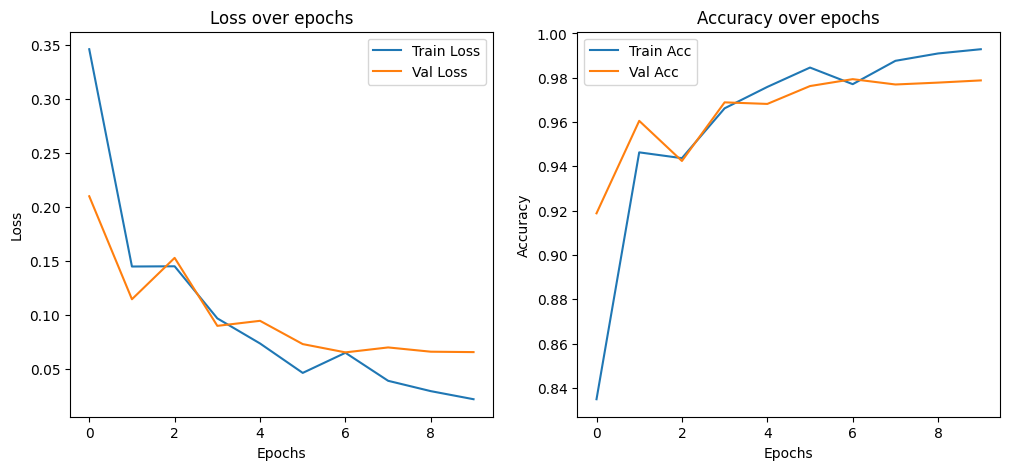

In [ ]:
# --------------------
# Entrenamiento y evaluación
# --------------------

# Instanciar modelo, pérdida y optimizador
model = BiLSTM().to(device)
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de entrenamiento
num_epochs = 10
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
best_model_path = "models/best_bilstm.pth"  # Ruta donde se guardará el mejor modelo

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

In [108]:
best_model_path = "models/best_bilstm.pth"
evaluate_model(model, test_loader, device, best_model_path)

C:\Users\guigr\AppData\Local\Temp\ipykernel_9120\2726994642.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Precisión en el conjunto de prueba: 0.9888
AUC-ROC en el conjunto de prueba: 0.9889


Podemos observar un rendimiento sobresaliente, alcanzando una precisión cercana al **99%** en el conjunto de prueba.

Además, cabe destacar que se han realizado distintas pruebas modificando **diversos parámetros** y se ha llegado a las siguientes conclusiones:
- batch_size: Disminuirlo empeora el resultado, aumentarlo tampoco lo mejora y hace el entrenamiento más lento.
- max_len: Aumentarlo no mejora el resultado significativamente, por lo que se seguirá usando *max_len=1024*.
- num_epochs: A partir de la época 10 el modelo comienza a sobreajustar al conjunto de entrenamiento.




#### Vectorización mediante Embeddings Preentrenados (*Word2Vec*)

En este enfoque, utilizamos **Word2Vec** en lugar de la capa de embeddings tradicional de PyTorch. Word2Vec es una técnica de word embeddings que aprende representaciones vectoriales densas de palabras a partir de un gran corpus de texto, de forma que palabras con contextos similares tienen vectores similares. A diferencia de un tokenizador con embeddings entrenables dentro de una red neuronal, Word2Vec entrena un **modelo independiente** que luego usamos para **codificar nuestras secuencias de texto**.

Tokenizaremos el texto con la función *simple_preprocess*, y entrenamos un modelo Word2Vec sobre los datos tokenizados del conjunto de entrenamiento. Posteriormente, al igual que en el ejemplo anterior, definimos una función que convierte cada documento en una secuencia de vectores utilizando el modelo Word2Vec, aplicando padding para asegurar una longitud fija por documento. Finalmente, transformamos los conjuntos obteniendo así tensores de forma (n_samples, max_len=1024, vector_size=64), manteniendo las dimensiones del ejemplo anterior.

De esta manera, podremos comparar si ofrecen mejores resultados los embeddings entrenados junto con la red neuronal o aquellos obtenidos previamente a través de un modelo ya entrenado como Word2Vec.

In [15]:
# Cargar el DataFrame limpio
df = pd.read_csv("Datasets/Cleaned-FR-News_V2.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Tokenize the text data
print("Tokenizing text data...")
X_train_tokens = [simple_preprocess(text) for text in X_train]
X_valid_tokens = [simple_preprocess(text) for text in X_valid]
X_test_tokens = [simple_preprocess(text) for text in X_test]

# Train Word2Vec model on the training data
print("Training Word2Vec model...")
word2vec_model = Word2Vec(
    sentences=X_train_tokens, 
    vector_size=64,    # Dimensionalidad de los embeddings
    window=10,         # Ventana para predecir el contexto
    min_count=5,       # Eliminar palabras raras (mínimo cada palabra debe aparecer 5 veces en el corpus)
    workers=4,         # Usar 4 hilos de CPU
)

def encode_text_with_word2vec(tokens_list, model, max_len):
    """
    Convierte una lista de documentos tokenizados en secuencias de embeddings de Word2Vec.

    Parámetros:
    - tokens_list: Lista de documentos tokenizados (lista de listas de palabras).
    - model: Modelo Word2Vec entrenado.
    - max_len: Longitud máxima de la secuencia para el padding.

    Retorna:
    - Un array de NumPy con forma (num_samples, max_len, vector_size)
    """
    embedded_sequences = []
    
    for tokens in tokens_list:
        embeddings = [model.wv[word] for word in tokens if word in model.wv]  # Convertir palabras a vectores
        embedded_sequences.append(embeddings)

    # Rellenar secuencias con ceros para garantizar una forma uniforme
    padded_embeddings = pad_sequences(embedded_sequences, maxlen=max_len, dtype='float32', padding='pre', truncating='pre', value=0.0)

    return np.array(padded_embeddings)

# Longitud máxima - Teniendo en cuenta que de media tenemos 1656 palabras.
max_len = 1024

# Convertir los datos de texto a embeddings de Word2Vec
print("Encoding train text data with Word2Vec...")
X_train_embedding = encode_text_with_word2vec(X_train_tokens, word2vec_model, max_len)
print("Encoding valid text data with Word2Vec...")
X_valid_embedding = encode_text_with_word2vec(X_valid_tokens, word2vec_model, max_len)
print("Encoding test text data with Word2Vec...")
X_test_embedding = encode_text_with_word2vec(X_test_tokens, word2vec_model, max_len)

print("Shape of X_train:", X_train_embedding.shape)
print("Shape of X_valid:", X_valid_embedding.shape)
print("Shape of X_test:", X_test_embedding.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Tokenizing text data...
Training Word2Vec model...
Encoding train text data with Word2Vec...
Encoding valid text data with Word2Vec...
Encoding test text data with Word2Vec...
Shape of X_train: (28283, 1024, 64)
Shape of X_valid: (7071, 1024, 64)
Shape of X_test: (8839, 1024, 64)
Shape of y_train: (28283,)
Shape of y_valid: (7071,)
Shape of y_test: (8839,)


In [16]:
# GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.empty_cache()
print("CUDA cache cleared.")

# Convertir datos a tensores de PyTorch cuando ya son arrays
def tensorize_w2v(data, labels):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
    return data_tensor, labels_tensor

X_train_tensor, y_train_tensor = tensorize_w2v(X_train_embedding, y_train)
X_valid_tensor, y_valid_tensor = tensorize_w2v(X_valid_embedding, y_valid)
X_test_tensor, y_test_tensor = tensorize_w2v(X_test_embedding, y_test)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Variables de configuración
batch_size = 128

# Create DataLoaders para entrenamiento y validación
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda
CUDA cache cleared.
Shape of X_train_tensor: torch.Size([28283, 1024, 64])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1024, 64])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1024, 64])
Shape of y_test_tensor: torch.Size([8839, 1])


In [ ]:
class BiLSTM_W2V(nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim_1=64, hidden_dim_2=32):
        super(BiLSTM_W2V, self).__init__()
        
        # Eliminamos la capa de embeddings entrenables

        self.bilstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim_1,
            batch_first=True,
            bidirectional=True
        )
        
        self.bilstm2 = nn.LSTM(
            input_size=hidden_dim_1*2,  # Porque es bidireccional (64 * 2)
            hidden_size=hidden_dim_2,
            batch_first=True,
            bidirectional=True
        )

        self.fc1 = nn.Linear(hidden_dim_2 * 2, 16)  # Salida de la segunda BiLSTM
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out, _ = self.bilstm1(x)  # (batch_size, seq_len, 128)
        out, _ = self.bilstm2(out)  # (batch_size, seq_len, 64)
        # Tomamos el último paso de la secuencia
        out = out[:, -1, :]  # (batch_size, 64)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)  # Para clasificación binaria

🔹 Saved best model at models/best_lstm_w2v.pth (Val Loss: 0.1321)
Epoch [1/20] - Loss: 0.2602 - Acc: 0.9060 - Val Loss: 0.1321 - Val Acc: 0.9516
Epoch [2/20] - Loss: 0.1305 - Acc: 0.9517 - Val Loss: 0.2411 - Val Acc: 0.8961
🔹 Saved best model at models/best_lstm_w2v.pth (Val Loss: 0.1181)
Epoch [3/20] - Loss: 0.1327 - Acc: 0.9532 - Val Loss: 0.1181 - Val Acc: 0.9593
🔹 Saved best model at models/best_lstm_w2v.pth (Val Loss: 0.0854)
Epoch [4/20] - Loss: 0.0950 - Acc: 0.9658 - Val Loss: 0.0854 - Val Acc: 0.9700
Epoch [5/20] - Loss: 0.0728 - Acc: 0.9754 - Val Loss: 0.1008 - Val Acc: 0.9646
🔹 Saved best model at models/best_lstm_w2v.pth (Val Loss: 0.0634)
Epoch [6/20] - Loss: 0.0582 - Acc: 0.9811 - Val Loss: 0.0634 - Val Acc: 0.9795
Epoch [7/20] - Loss: 0.0542 - Acc: 0.9819 - Val Loss: 0.0790 - Val Acc: 0.9716
🔹 Saved best model at models/best_lstm_w2v.pth (Val Loss: 0.0544)
Epoch [8/20] - Loss: 0.0441 - Acc: 0.9858 - Val Loss: 0.0544 - Val Acc: 0.9846
Epoch [9/20] - Loss: 0.0393 - Acc: 0.9

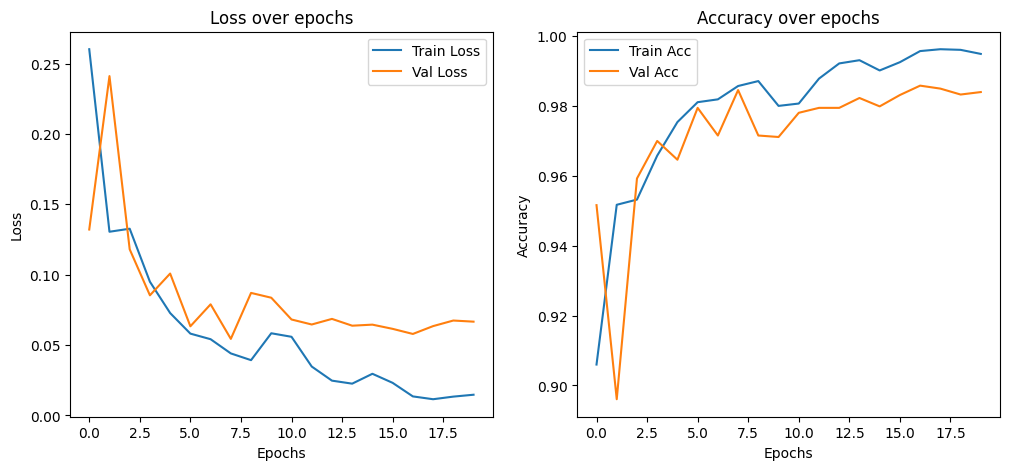

C:\Users\guigr\AppData\Local\Temp\ipykernel_17928\2726994642.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Precisión en el conjunto de prueba: 0.9834
AUC-ROC en el conjunto de prueba: 0.9835


In [19]:
# Instanciar modelo y moverlo a GPU si está disponible
model = BiLSTM_W2V().to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de entrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_lstm_w2v.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device, best_model_path)

De nuevo, obtenemos un gran resultado con una precisión en el conjunto de prueba del **98.34%**, aunque no se supera el rendimiento obtenido utilizando el *Tokenizer* junto con la capa de *Embeddings entrenables* durante la red neuronal.

#### ¿Por qué la vectorización mediante Embeddings como *BERT* o *allMiniLM* (token a token) no tiene sentido?

1. Consumiría demasiada memoria: Generar embeddings de **768** dimensiones para cada token en secuencias de **512** para los aproximadamente **28.000** textos únicamente del conjunto de train crearía **tensores gigantescos (40 GB)** que no caben en la RAM.
2. Es **computacionalmente carísimo**, procesar estas secuencias masivas con una LSTM sería **extremadamente lento**.
3. Probablemente es **redundante**, haciendo que la LSTM sobre todos los tokens sea potencialmente innecesaria. 
4. Beneficio marginal vs. coste: Con un 99% de precisión ya alcanzado, **la posible mejora no justifica el inmenso coste y complejidad**. 

#### Introducción de una capa de Self-Attention

In [8]:
# --------------------
# Tokenización y secuencias
# --------------------
# Disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Número máximo de palabras a considerar en el vocabulario
max_words = 10000
# Longitud máxima de las secuencias - La media de longitud de los textos es 1656 aproximadamente
max_len = 1024

# Inicializar el tokenizador de TensorFlow con un vocabulario limitado y un token para palabras 'Out-Of-Vocabulary'
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de índices y aplicar padding
X_train_embedding = tokenizer.texts_to_sequences(X_train)
X_train_embedding = pad_sequences(X_train_embedding, maxlen=max_len)
X_valid_embedding = tokenizer.texts_to_sequences(X_valid)
X_valid_embedding = pad_sequences(X_valid_embedding, maxlen=max_len)
X_test_embedding = tokenizer.texts_to_sequences(X_test)
X_test_embedding = pad_sequences(X_test_embedding, maxlen=max_len)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_embedding, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid_embedding, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_embedding, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of y_valid_tensor:", y_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

# Batch Size
batch_size = 128

# Crear Datasets & DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Usando device: cuda
Shape of X_train_tensor: torch.Size([28283, 1024])
Shape of y_train_tensor: torch.Size([28283, 1])
Shape of X_valid_tensor: torch.Size([7071, 1024])
Shape of y_valid_tensor: torch.Size([7071, 1])
Shape of X_test_tensor: torch.Size([8839, 1024])
Shape of y_test_tensor: torch.Size([8839, 1])


Anteriormente, el modelo BiLSTM procesaba toda la noticia pero, para decidir si era real o falsa, se basaba principalmente en la información resumida en **el último estado oculto** (el resultado de out[:, -1, :]). La idea era que este último estado ya contenía una buena síntesis de todo lo leído. Sin embargo, esta estrategia fija le da más peso al final del texto y podría **pasar por alto pistas cruciales que aparezcan al principio o en medio de la noticia**.

Aunque existen alternativas como **Max Pooling** o **Mean Pooling**, se optó por incorporar una capa de **Self-Attention**. Al colocar la Self-Attention después de la BiLSTM, en lugar de utilizar únicamente el último estado oculto, la atención examina toda la secuencia de estados ocultos que generó la BiLSTM. Así, **aprende dinámicamente a asignar pesos de importancia a cada parte de la secuencia** (a cada palabra o frase representada por su estado oculto). De esta manera, crea un nuevo vector resumen **(vector de contexto)** que es una **combinación ponderada de toda la información**, dando más énfasis a las partes que el propio modelo considera más relevantes para la clasificación, sin importar si están al principio, en medio o al final.

In [10]:
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim=max_words, embedding_dim=64, hidden_dim_1=64, hidden_dim_2=32, num_heads=4):
        super(BiLSTMAttention, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        
        self.bilstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim_1,
            batch_first=True,
            bidirectional=True
        )
        
        self.bilstm2 = nn.LSTM(
            input_size=hidden_dim_1 * 2,
            hidden_size=hidden_dim_2,
            batch_first=True,
            bidirectional=True
        )
        
        bilstm_output_dim = hidden_dim_2 * 2

        if bilstm_output_dim % num_heads != 0:
             raise ValueError(f"hidden_dim_2 * 2 ({bilstm_output_dim}) debe ser divisible por num_heads ({num_heads})")
        self.attention = nn.MultiheadAttention(
            embed_dim=bilstm_output_dim, # Dimensión total de entrada/salida
            num_heads=num_heads,         # Número de cabezas de atención
            dropout=0.1,                 # Dropout opcional en atención
            batch_first=True             # Para que acepte (batch, seq, feature)
        )

        self.fc1 = nn.Linear(bilstm_output_dim, 16) # La dimensión de salida de la atención es la misma que la entrada
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        out, _ = self.bilstm1(x)  # (batch_size, seq_len, hidden_dim_1 * 2)
        out, _ = self.bilstm2(out) # (batch_size, seq_len, hidden_dim_2 * 2)
        
        # MultiheadAttention espera query, key, value.
        # Devuelve: attn_output (batch, seq, embed_dim), attn_output_weights (batch, num_heads, seq, seq) o similar
        attn_output, attn_weights = self.attention(out, out, out) # attn_output shape: (batch_size, seq_len, hidden_dim_2 * 2)
        
        # Promediamos los outputs de atención a lo largo de la secuencia.
        context = torch.mean(attn_output, dim=1) # (batch_size, hidden_dim_2 * 2)
        # ------------------------

        # Usamos el vector de contexto en lugar del último estado oculto
        out = self.fc1(context) # (batch_size, 16)
        out = self.relu(out) 
        out = self.fc2(out)     # (batch_size, 1)
        return self.sigmoid(out)

Debido a la introducción de la capa de Self-Attention, que es muy costosa computacionalmente, vamos a introducir **Early-Stopping** en el método de entrenamiento para poder pararlo cuando la pérdida haya dejado de mejorar.

In [23]:
def train_model_optimized(
    model, train_loader, valid_loader, criterion, optimizer,
    num_epochs, device, best_model_path, patience=5
):
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        valid_loss, correct_valid, total_valid = 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                valid_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                correct_valid += (predicted == y_batch).sum().item()
                total_valid += y_batch.size(0)

        val_loss_avg = valid_loss / len(valid_loader)
        val_acc = correct_valid / total_valid
        valid_losses.append(val_loss_avg)
        valid_accuracies.append(val_acc)

        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), best_model_path)
            print(f"🔹 Saved best model at {best_model_path} (Val Loss: {best_val_loss:.4f})")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"🔸 No improvement for {epochs_without_improvement} epoch(s)")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f} - Val Loss: {val_loss_avg:.4f} - Val Acc: {val_acc:.4f}")

        if epochs_without_improvement >= patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs.")
            break

    return train_losses, valid_losses, train_accuracies, valid_accuracies


CUDA cache cleared.
🔹 Saved best model at models/best_lstm_attention.pth (Val Loss: 0.1374)
Epoch [1/20] - Loss: 0.3516 - Acc: 0.8233 - Val Loss: 0.1374 - Val Acc: 0.9458
🔹 Saved best model at models/best_lstm_attention.pth (Val Loss: 0.0827)
Epoch [2/20] - Loss: 0.0930 - Acc: 0.9659 - Val Loss: 0.0827 - Val Acc: 0.9693
🔹 Saved best model at models/best_lstm_attention.pth (Val Loss: 0.0486)
Epoch [3/20] - Loss: 0.0519 - Acc: 0.9813 - Val Loss: 0.0486 - Val Acc: 0.9826
🔹 Saved best model at models/best_lstm_attention.pth (Val Loss: 0.0413)
Epoch [4/20] - Loss: 0.0272 - Acc: 0.9909 - Val Loss: 0.0413 - Val Acc: 0.9866
🔹 Saved best model at models/best_lstm_attention.pth (Val Loss: 0.0400)
Epoch [5/20] - Loss: 0.0156 - Acc: 0.9952 - Val Loss: 0.0400 - Val Acc: 0.9866
🔸 No improvement for 1 epoch(s)
Epoch [6/20] - Loss: 0.0102 - Acc: 0.9967 - Val Loss: 0.0471 - Val Acc: 0.9868
🔸 No improvement for 2 epoch(s)
Epoch [7/20] - Loss: 0.0062 - Acc: 0.9980 - Val Loss: 0.0532 - Val Acc: 0.9878
🔸 N

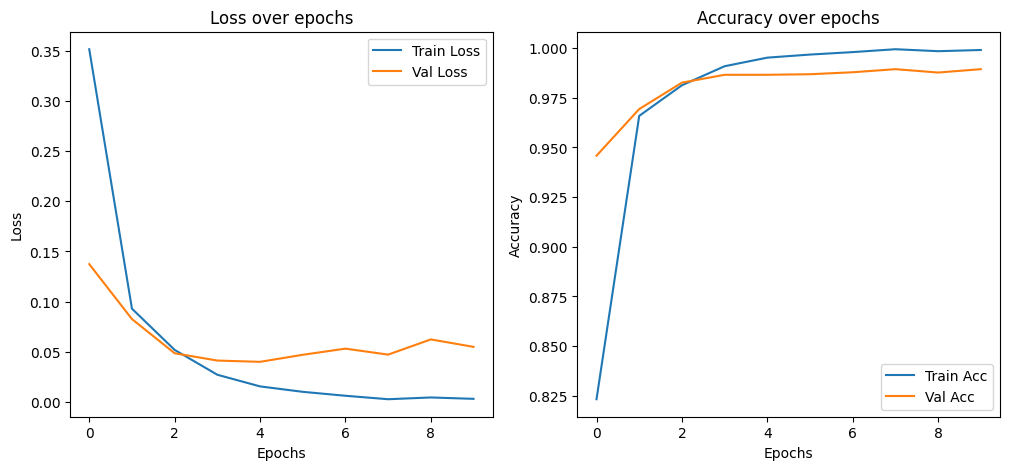

C:\Users\guigr\AppData\Local\Temp\ipykernel_10880\2726994642.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Precisión en el conjunto de prueba: 0.9888
AUC-ROC en el conjunto de prueba: 0.9888


In [24]:
# Limpiar la caché de CUDA para liberar memoria
torch.cuda.empty_cache()
print("CUDA cache cleared.")

# Instanciar modelo y moverlo a GPU si está disponible
model = BiLSTMAttention().to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()  # Pérdida para clasificación binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Variables de entrenamiento
num_epochs = 20
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# Ruta donde se guardará el mejor modelo
best_model_path = "models/best_lstm_attention.pth"  

# Entrenar el modelo
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_optimized(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs, device, best_model_path, patience=5
)

# Función para graficar la pérdida y precisión
plot_loss_and_accuracy(train_losses, valid_losses, train_accuracies, valid_accuracies)

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, test_loader, device, best_model_path)

Una vez más, logramos una **precisión del 99%** en el conjunto de prueba. Sin embargo, el coste computacional asociado con la incorporación de la capa de atención (el entrenamiento duró alrededor de 50 minutos, en contraste con el otro modelo que alcanzaba el mismo rendimiento en solo 2 minutos) no justifica la diferencia. De hecho, destacaría que se alcanza **exactamente la misma precisión** que con el modelo anterior, aunque en este caso la **convergencia a la pérdida óptima ocurre mucho más rápidamente**, alcanzándose en la quinta época (0.04).

Tras todos estos experimentos, llegamos a la conclusión de que, para el split que estamos utilizando, la precisión es **difícilmente mejorable**.

#### ¿Vale la pena optimizar hiperparámetros?

Se concluyó que, dado que el mejor modelo ya alcanza un 99% de precisión, no resulta justificado emplear frameworks de **optimización de hiperparámetros** como *Optuna* en este caso. El entrenamiento más reciente tomó cerca de 60 minutos, y el coste computacional —tanto en tiempo como en recursos— de ejecutar múltiples pruebas variando parámetros como *lstm_units* o *batch_size* (los cuales ya fueron explorados previamente en experimentos reducidos) sería **elevado en relación con la posible mejora**, que como máximo sería del 1%.

#### ¿Y aumentar **max_words**?

Vamos a realizar un análisis sobre cómo el Tokenizer transforma las oraciones y cuántas palabras terminan siendo codificadas en el proceso.

Example of sentence with <OOV> tokens: <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <

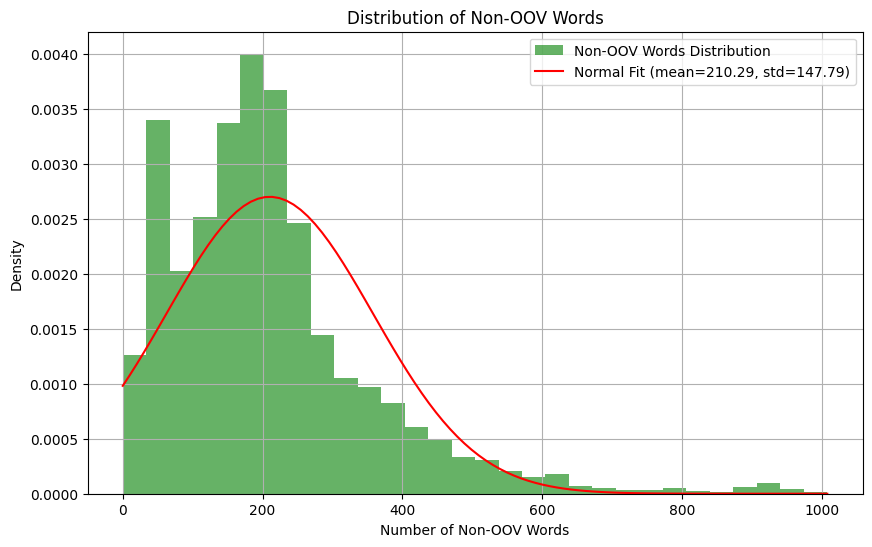

In [101]:
decoded_texts = tokenizer.sequences_to_texts([X_test_embedding[0]])
print(f"Example of sentence with <OOV> tokens: {decoded_texts[0]}")
print(f"Number of words in the decoded text: {len(decoded_texts[0].split())}, Number of non-<OOV> words: {num_non_oov_words}")

# Find the X_test_embedding with the minimum and maximum number of <OOV> words
min_oov_index = None
max_oov_index = None
min_oov_count = float('inf')
max_oov_count = float('-inf')

for i, embedding in enumerate(X_test_embedding):
    decoded_text = tokenizer.sequences_to_texts([embedding])[0]
    oov_count = sum(1 for word in decoded_text.split() if word == '<OOV>')
    
    if oov_count < min_oov_count:
        min_oov_count = oov_count
        min_oov_index = i
    
    if oov_count > max_oov_count:
        max_oov_count = oov_count
        max_oov_index = i

print()
print(f"Index with minimum <OOV> words: {min_oov_index}, Count: {min_oov_count}")
print(f"Index with maximum <OOV> words: {max_oov_index}, Count: {max_oov_count}")

# Count the number of embeddings with more than 1000, more than 500, and less than 100 non-<OOV> words
count_more_than_1000 = 0
count_more_than_500 = 0
count_less_than_100 = 0

for embedding in X_test_embedding:
    decoded_text = tokenizer.sequences_to_texts([embedding])[0]
    non_oov_count = sum(1 for word in decoded_text.split() if word != '<OOV>')
    
    if non_oov_count > 1000:
        count_more_than_1000 += 1
    if non_oov_count > 500:
        count_more_than_500 += 1
    if non_oov_count < 100:
        count_less_than_100 += 1

print()
print(f"Number of embeddings: {len(X_test_embedding)}")
print(f"Number of embeddings with more than 1000 non-<OOV> words: {count_more_than_1000}")
print(f"Number of embeddings with more than 500 non-<OOV> words: {count_more_than_500}")
print(f"Number of embeddings with less than 100 non-<OOV> words: {count_less_than_100}")

# Calculate the number of non-OOV words for each embedding
non_oov_counts = [
    sum(1 for word in tokenizer.sequences_to_texts([embedding])[0].split() if word != '<OOV>')
    for embedding in X_test_embedding
]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(non_oov_counts, bins=30, density=True, alpha=0.6, color='g', label='Non-OOV Words Distribution')

# Fit a normal distribution
mean, std = np.mean(non_oov_counts), np.std(non_oov_counts)
x = np.linspace(min(non_oov_counts), max(non_oov_counts), 100)
pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
plt.plot(x, pdf, 'r', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')

plt.title('Distribution of Non-OOV Words')
plt.xlabel('Number of Non-OOV Words')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

Al imprimir cualquier ejemplo de una frase procesada por el *Tokenizer*, observamos que la mayoría de las frases contienen en su mayoría el token 'OOV'. Por ejemplo, en la anterior frase, solo 35 de los 1024 tokens corresponden a palabras reales.

De hecho, al analizar la **distribución del número de palabras Non-OOV** (Out-of-Vocabulary) en cada frase de 1024 tokens, encontramos que la media está cerca de 200. Es decir, lo común es que alrededor del 80% del texto codificado sea el token 'OOV', el cual no aporta información útil.

Aunque esto podría sugerir que sería necesario aumentar el tamaño del vocabulario, dado que el Tokenizer selecciona las palabras más frecuentes (las cuales tienden a ser las más relevantes, como vimos con TF-IDF), se realizaron pruebas duplicando el valor de max_words a 20.000, pero los resultados no mejoraron. De hecho, en algunos casos, podría ser más beneficioso reducir ese valor para simplificar la complejidad.

#### Comprobando resultados de Test

A continuación, se verifica que un total de 99 textos fueron clasificados incorrectamente, de un total de 8839 pertenecientes al conjunto de prueba. Cabe destacar que estos textos son normales, es decir, no presentan transformaciones u otras condiciones que puedan justificar una mala clasificación.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")
model = BiLSTM().to(device)
best_model_path = "models/best_bilstm.pth"
evaluate_model(model, test_loader, device, best_model_path)

Usando device: cuda


C:\Users\guigr\AppData\Local\Temp\ipykernel_9120\2726994642.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Precisión en el conjunto de prueba: 0.9888
AUC-ROC en el conjunto de prueba: 0.9889


In [ ]:
# Evaluar el modelo en el conjunto de prueba y obtener predicciones
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

misclassified_indices = []
misclassified_texts = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.cpu().numpy()
        outputs = model(X_batch).cpu().numpy()
        preds = (outputs >= 0.5).astype(int)

        # Identificar índices donde las predicciones no coinciden con las etiquetas reales
        for j in range(len(y_batch)):
            if preds[j] != y_batch[j]:
                misclassified_indices.append(i * batch_size + j)
                misclassified_texts.append(X_test.iloc[i * batch_size + j])
                misclassified_labels.append(y_batch[j])
                misclassified_predictions.append(preds[j])

# Crear un DataFrame con las noticias mal clasificadas
misclassified_df = pd.DataFrame({
    "Text": misclassified_texts,
    "True Label": misclassified_labels,
    "Predicted Label": misclassified_predictions
})

print(f"Total misclassified samples: {len(misclassified_df)}")
misclassified_df.head()

C:\Users\guigr\AppData\Local\Temp\ipykernel_3544\255346102.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Total misclassified samples: 99


,Text,True Label,Predicted Label
0,los angeles comedian kathy griffin tearfully ...,[1.0],[0]
1,also map show state accept refugee syria make ...,[0.0],[1]
2,turn trump rally oppose republican frontrunner...,[0.0],[1]
3,davos switzerland global economy well shape ye...,[1.0],[0]
4,president trump announce play golf quickly jup...,[0.0],[1]


## Explicabilidad Mejor Modelo

El método **Deep Explainer** de SHAP no puede utilizar los 28.000 datos de entrenamiento completos debido a las limitaciones computacionales al calcular los **valores SHAP para cada muestra** en un modelo complejo como **BiLSTM** (El proceso requiere evaluar el modelo en múltiples combinaciones de características).

Por esta razón, se seleccionan **muestras de fondo** (background samples), para aproximar el valor esperado de la salida del modelo (E[f(x)]). La aproximación se basa en la idea de que la diferencia entre la salida del modelo para una muestra específica f(x) y el valor esperado E[f(x)] (promedio de las salidas sobre las muestras de fondo) refleja cómo una característica en particular contribuye a la predicción para esa muestra. El uso de estas muestras permite realizar estimaciones eficientes de los valores SHAP **sin sacrificar la calidad de las explicaciones**. 

In [64]:
torch.cuda.empty_cache()
print("CUDA cache cleared.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")
model = BiLSTM()
best_model_path = "models/best_bilstm.pth"
model.state_dict(torch.load(best_model_path))
model.to(device)
print("Model loaded successfully.")

CUDA cache cleared.
Usando device: cuda
Model loaded successfully.


C:\Users\guigr\AppData\Local\Temp\ipykernel_828\690650864.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.state_dict(torch.load(best_model_path))
C:\Users\guigr\Ap

Se creó un submodelo que omite la capa de embeddings del modelo original para poder trabajar directamente con entradas de tipo **flotante**, en lugar de las **representaciones enteras** que utiliza el modelo original. Este submodelo conserva las mismas capas del modelo original, pero en lugar de recibir entradas de enteros, recibe las entradas ya transformadas en embeddings. De esta manera, se logra que el modelo **sea compatible con los requisitos de gradientes** y pueda ser utilizado en el proceso de explicación con **SHAP**.

In [90]:
# Crear un modelo que reciba embeddings como entrada
class BiLSTM_WithoutEmbedding(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.bilstm1 = original_model.bilstm1
        self.bilstm2 = original_model.bilstm2
        self.fc1 = original_model.fc1
        self.relu = original_model.relu
        self.fc2 = original_model.fc2
        self.sigmoid = original_model.sigmoid

    def forward(self, embedded_input):
        out, _ = self.bilstm1(embedded_input)
        out, _ = self.bilstm2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

# Instanciar el submodelo
model_embedded = BiLSTM_WithoutEmbedding(model).to(device)

# Obtenemos los embeddings como entrada para SHAP
background = X_train_tensor[:250].to(device)
background_embedded = model.embedding(background)

test = X_test_tensor[:25].to(device)
test_embedded = model.embedding(test)

# SHAP Deep Explainer
explainer = shap.DeepExplainer(model_embedded, background_embedded)
shap_values = explainer.shap_values(test_embedded)

c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Guardamos las 25 secuencias tokenizadas con el *Tokenizer*. 

Podemos ver como obtenemos los *feature_names* al hacer la transformación inversa con el *Tokenizer*.

In [67]:
# Generar 25 secuencias tokenizadas del conjunto de datos de prueba
sequences = tokenizer.texts_to_sequences(X_test[:25])

# Imprimir las primeras secuencias para verificar
print(f"Secuencia tokenizada a integers: {sequences[0]}")

# Mapear la primera secuencia de vuelta a palabras
mapped_sequence = [tokenizer.index_word.get(index, '<OOV>') for index in sequences[0]]

# Unir las palabras en una oración
mapped_sentence = ' '.join(mapped_sequence)

# Imprimir la oración mapeada
print(f"Secuencia mediante transformación inversa: {mapped_sentence}")
# Imprimir el primer texto de X_test
print(f"Secuencia original: {X_test.iloc[0]}")


Secuencia tokenizada a integers: [4282, 2146, 497, 19, 620, 151, 711, 115, 27, 67, 1426, 501, 111, 1277, 1743, 68, 270, 376, 127, 168, 15, 127, 131, 72, 98, 88, 1205, 620, 1141, 690, 95, 501, 254, 1407, 311]
Secuencia mediante transformación inversa: warsaw poland low house parliament friday approve change country national judiciary council part broad overhaul court system push rule conservative new rule still need senate presidential approval parliament responsibility choose member council turn nominate judge
Secuencia original: warsaw  poland low house parliament friday approve change country national judiciary council part broad overhaul court system push rule conservative new rule still need senate presidential approval parliament responsibility choose member council turn nominate judge


Ahora mismo tenemos predicciones para cada noticia, cada paso de tiempo de la secuencia cada característica que conforma el embedding.

In [91]:
shap_values.shape

(25, 1024, 64, 1)

In [101]:
# Find the maximum and minimum values in shap_values
max_shap_value = shap_values.max()
min_shap_value = shap_values.min()

print(f"Maximum SHAP value: {max_shap_value}")
print(f"Minimum SHAP value: {min_shap_value}")

Maximum SHAP value: 0.0015581878833472729
Minimum SHAP value: -0.001888215309008956


Cada valor en la matriz resultante de (25, 1024) representa la contribución media (para la clasificación) del embedding completo de cada token (palabra) a la salida del modelo.

In [92]:
# Aplanar los valores SHAP promediando a través de dimensiones
shap_values_flat = np.mean(shap_values, axis=3)
shap_values_flat = np.mean(shap_values_flat, axis=2)
shap_values_flat.shape

(25, 1024)

In [102]:
# Find the maximum and minimum values in shap_values
max_shap_value = shap_values_flat.max()
min_shap_value = shap_values_flat.min()

print(f"Maximum SHAP value: {max_shap_value}")
print(f"Minimum SHAP value: {min_shap_value}")

Maximum SHAP value: 6.341060205272697e-05
Minimum SHAP value: -7.853382268452336e-05


Ahora calculamos la importancia media absoluta de cada token a lo largo de los 25 ejemplos.

In [93]:
# Calcular la importancia promedio (valor absoluto) de cada posición a lo largo del tiempo
token_importance = np.mean(np.abs(shap_values_flat), axis=0)  # Tamaño (1024,)

Filtrar solo aquellas posiciones que en al menos una secuencia contienen un token real (diferente del padding, 0)

In [94]:
valid_indices = []
for i in range(len(token_importance)):
    # Se recorre cada secuencia y se comprueba si en la posición i existe un token distinto de 0
    if any((i < len(seq) and seq[i] != 0) for seq in sequences):
        valid_indices.append(i)
        top_indices = np.argsort(token_importance)[-20:]  # Selecciona 20 posiciones más importantes

if not valid_indices:
    raise ValueError("No se encontraron posiciones con tokens válidos.")

Seleccionar, de entre las posiciones válidas, las 20 con mayor importancia

In [95]:
valid_importance = token_importance[valid_indices]
top_valid_indices_sorted = np.array(valid_indices)[np.argsort(valid_importance)[-20:]]
top_valid_indices_sorted

array([202, 201, 200, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 183, 585])

In [96]:
index_to_token = {}
for idx in top_valid_indices_sorted:
    # Recoger los tokens de esta posición que sean distintos de 0
    non_padding_token_ids = [seq[idx] for seq in sequences if idx < len(seq) and seq[idx] != 0]
    if non_padding_token_ids:
        most_common_token = Counter(non_padding_token_ids).most_common(1)[0][0]
        # Obtener el nombre original utilizando el mapping del tokenizer.
        index_to_token[idx] = tokenizer.index_word.get(most_common_token, '<OOV>')
    else:
        index_to_token[idx] = f"pos_{idx}" # Esto no debería ocurrir, pues hemos filtrado.

feature_names = [index_to_token[idx] for idx in top_valid_indices_sorted]
feature_names

['country',
 'want',
 'also',
 'tim',
 'scott',
 'also',
 'oppose',
 'house',
 'people',
 'scott',
 'state',
 'america',
 'leader',
 'fix',
 '<OOV>',
 'illegal',
 'immigration',
 'problem',
 'carolina',
 'production']

Se extraen los valores SHAP correspondientes a esos 20 tokens para todos los ejemplos.

In [97]:
top_shap_values = shap_values_flat[:, top_valid_indices_sorted]

Generar el summary plot con SHAP

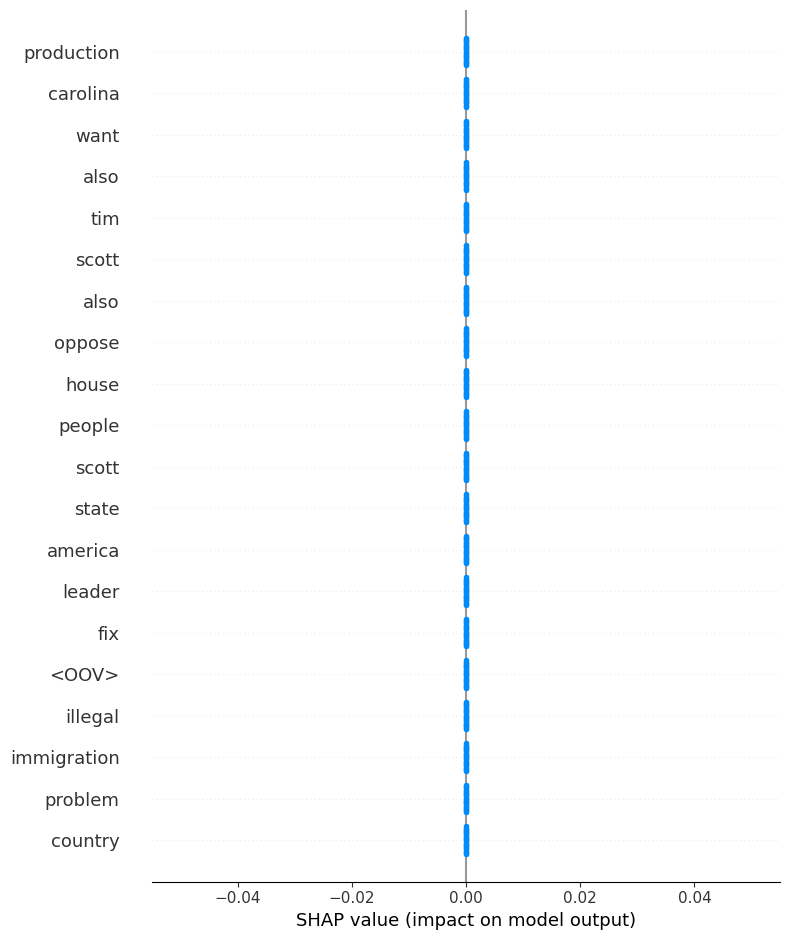

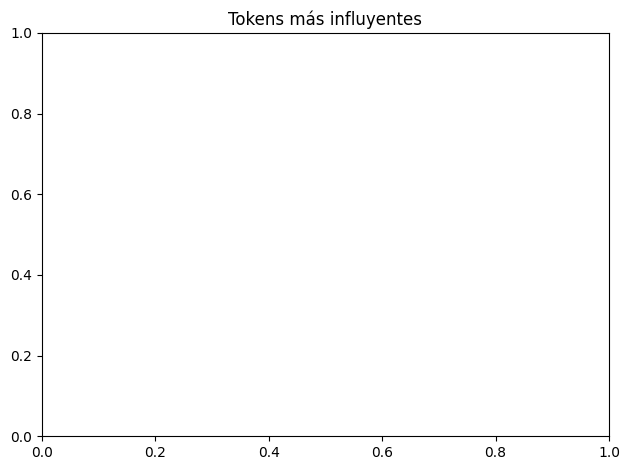

In [63]:
plt.figure(figsize=(10, 8))
shap.summary_plot(top_shap_values, feature_names=feature_names)
plt.title("Tokens más influyentes")
plt.tight_layout()
plt.show()